In [1]:
import os
import cv2
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

from dotenv import load_dotenv
from glob import glob

from supabase import create_client, Client
import json

from PIL import Image
from io import BytesIO

load_dotenv()

True

In [2]:
def init_supabase(url: str, key: str) -> Client:
    supabase: Client = create_client(url, key)
    return supabase

def retreive_data_from_table(supabase, table_name, limit = -1):
    res = supabase.table(table_name).select("*")
    if limit >0:
        res = res.limit(10)
    return res.execute().data

In [3]:
supa_url = os.getenv("SUPABASE_URL")
supa_key = os.getenv("SUPABASE_API_KEY")

table_name = "PubTab1M"
bucket_name = "PubTab1M-images"
supabase = init_supabase(supa_url, supa_key)
get_basename = lambda f: os.path.basename(f)
remove_ext = lambda f: os.path.splitext(get_basename(f))[0] if isinstance(f, str) else f
str_to_json = lambda f: json.loads(f) if isinstance(f, str) else f
retreive_data_from_bucket = lambda fname: supabase.storage.from_(bucket_name).download(fname)

def buffer_to_np(fname):
    buffer = retreive_data_from_bucket(fname)
    img = Image.open(BytesIO(buffer)).convert("RGB")
    return np.array(img, dtype="uint8")


def show_image(image: np.array):
    plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None)
    plt.axis('off')

def get_val_from_json(data, val_name, root_key_name = None):
    val = [c.get(val_name, []) for c in (data[root_key_name] if root_key_name else data)]
    return val

def upate_val_in_json(data, root_key_name, val_name, new_vals):
    for ind, row in enumerate(data[root_key_name]):
        if val_name in row:
            row[val_name] = new_vals[ind]
    return data

def kv_mapper(keys, values):
    assert len(keys) == len(values), "Keys and values must have the same length"
    n = len(keys)
    data = {keys[i]:values[i] for i in range(n)}
    return data

def replicate_chunks(pos, mapper, augmented_ids):
    data = {'chunks': []} 
    for i, p in enumerate(pos):
        data['chunks'].append({
            'pos'  : p,
            'text' : mapper[augmented_ids[i]],
        })
    return data 

In [4]:
data = retreive_data_from_table(supabase, table_name, 10)
sample = data[0]

In [5]:
i = sample['name'] + '.jpg'
struct = sample['struct']
words = sample['words']
struct

{'size': {'width': 657, 'height': 142},
 'objects': [{'name': 'table', 'bbox': [37.3586, 37.0904, 618.2697, 102.8725]},
  {'name': 'table column header',
   'bbox': [37.3586, 37.0904, 618.2697, 57.0645]},
  {'name': 'table row', 'bbox': [37.3586, 37.0904, 618.2697, 57.0645]},
  {'name': 'table row', 'bbox': [37.3586, 57.0645, 618.2697, 77.595]},
  {'name': 'table row', 'bbox': [37.3586, 77.595, 618.2697, 90.5119]},
  {'name': 'table row', 'bbox': [37.3586, 90.5119, 618.2697, 102.8725]},
  {'name': 'table column', 'bbox': [37.3586, 37.0904, 163.988, 102.8725]},
  {'name': 'table column', 'bbox': [163.988, 37.0904, 347.3245, 102.8725]},
  {'name': 'table column', 'bbox': [347.3245, 37.0904, 502.8367, 102.8725]},
  {'name': 'table column', 'bbox': [502.8367, 37.0904, 618.2697, 102.8725]}]}

In [6]:
words[10]['bbox'][0]

331.2226767676767

In [7]:
img = buffer_to_np(i)
img.shape

(142, 657, 3)

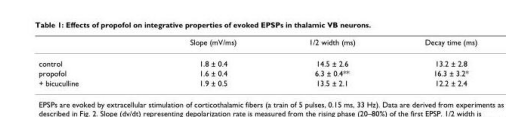

In [8]:
show_image(img)

In [9]:
def render_text_positions(data_dict, img_size, label_key = 'text'):
    """
    Create a black image and render text at specified positions.

    Args:
        data_dict (dict): {'objects': [{'name': 'table', 'bbox': [37.3586, 37.0904, 618.2697, 102.8725]} -> [xmin, ymin, xmax, ymax]
        img_size (tuple): (height, width) of the output image

    Returns:
        np.ndarray: image with rendered text
    """
    # Create a black image
    img = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)

    # Font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    color = (255, 255, 255)  # white text
    thickness = 1

    # Process each chunk
    for chunk in data_dict.get('objects', []):
        pos = chunk.get('bbox')
        text = chunk.get(label_key, '')
        if not pos or len(pos) != 4:
            continue  # skip invalid positions

        x1, y1, x2, y2 = pos
        x = int(x1)
        y = int((y1 + y2) // 2)

        # Ensure x and y are within image bounds
        if 0 <= x < img_size[1] and 0 <= y < img_size[0] and text != '':
            cv2.putText(img, text, (x, y), font, font_scale, color, thickness, lineType=cv2.LINE_AA)

    return img

def render_bbox(data_dict, image, root_keyname = None, label_keyname = 'name'):
    """
    Create a black image and render text at specified positions.

    Args:
        data_dict (dict): {'objects': [{'name': 'table', 'bbox': [37.3586, 37.0904, 618.2697, 102.8725]} -> [xmin, ymin, xmax, ymax]
        img_size (tuple): (height, width) of the output image

    Returns:
        np.ndarray: image with rendered text
    """
    img = image.copy()
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
    # Font settings
    objects = (data_dict[root_keyname] if root_keyname else data_dict)
    elems = [d[label_keyname] for d in objects]
    colors = get_colors_mapper(elems)
    thickness = 1

    for obj in objects:
        x1,y1,x2,y2 = list(map(int, obj['bbox']))
        cv2.rectangle(img, (x1,y1), (x2,y2), colors[obj[label_keyname]], thickness=thickness)

    return img

def get_colors_mapper(elems, cmap='tab10'):
    colors = cm.get_cmap(cmap)
    elems= np.unique(elems)
    hmap = {elems[i]: colors(i) for i in range(len(elems))}
    return hmap

def plot_image_vs_render(indexes, tdataset):
    """
    Plots original grayscale images and rendered text overlays side by side.

    Args:
        indexes (list of int): List of indices to visualize
        tdataset (Dataset): PyTorch dataset with 'image' and 'chunks'
    """
    n = len(indexes)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 4 * n))

    # Handle the case when n == 1
    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, idx in enumerate(indexes):
        sample = tdataset[idx]
        img_tensor = sample['image']  
        objects = sample['words']    

        # Convert grayscale image tensor to numpy (C=1, H, W) -> (H, W)
        img_np = img_tensor.numpy()

        # Get image shape for render_text_positions
        img_h, img_w = img_np.shape
        rendered = render_text_positions({'objects': objects}, (img_h, img_w))

        # Plot original grayscale image
        ax1 = axes[row, 0]
        ax1.imshow(img_np, cmap='gray')
        ax1.set_title(f"Original Grayscale (idx={idx})")
        ax1.axis('off')

        # Plot rendered RGB image
        ax2 = axes[row, 1]
        ax2.imshow(cv2.cvtColor(rendered, cv2.COLOR_BGR2RGB))
        ax2.set_title("Rendered Text Positions")
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

def plot_image_and_bbox(indexes, tdataset):
    """
    Plots original grayscale images and rendered text overlays side by side.

    Args:
        indexes (list of int): List of indices to visualize
        tdataset (Dataset): PyTorch dataset with 'image' and 'chunks'
    """
    n = len(indexes)
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(15, 4 * n))

    # Handle the case when n == 1
    if n == 1:
        axes = np.expand_dims(axes, axis=0)

    for row, idx in enumerate(indexes):
        sample = tdataset[idx]
        img_tensor = sample['image']  
        words = sample['words']    
        struct = sample['struct']    

        # Convert grayscale image tensor to numpy (C=1, H, W) -> (H, W)
        if len(img_tensor.shape) == 3:
            img_tensor = img_tensor.permute(1,2,0)
        img_np = img_tensor.numpy()

        if len(img_np.shape) == 3:
            img_np = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)

        # Get image shape for render_text_positions
        img_h, img_w = img_np.shape
        layout_img = render_bbox(struct, img_np, 'objects')
        words_img = render_bbox(words, img_np, label_keyname='block_num')

        # Plot original grayscale image
        ax1 = axes[row, 0]
        ax1.imshow(img_np, cmap='gray')
        ax1.set_title(f"(idx={idx}) | {(img_h, img_w)}")
        ax1.axis('off')

        # Plot rendered bbox RGB image
        ax2 = axes[row, 1]
        ax2.imshow(layout_img)
        ax2.set_title("Document Layout Bbox")
        ax2.legend()
        ax2.axis('off')

        # Plot rendered bbox RGB image
        ax2 = axes[row, 2]
        ax2.imshow(words_img)
        ax2.set_title("Document Layout Bbox [text]")
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [207]:
import torch 
from torch.utils.data import Dataset, DataLoader


class TableDataset(Dataset):
    def __init__(self, metadata, transform=False, img_size=224, n_channels=2):
        """
        Args:
            metadata (list[dict]): a single row contains [id, filename, document structure metadata, text metadata]
            transform (callable, optional): Transformations for image preprocessing
            img_size (int): resize target for images if no transform given
        """
        self.data = metadata
        self.transform = transform
        self.img_size = img_size
        self.n_channels = n_channels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # --- read image ---
        img_path = self.data[idx]['name'] + '.jpg'
        struct = self.data[idx]['struct']
        words = self.data[idx]['words']
        img = buffer_to_np(img_path)

        if self.n_channels == 2 and len(img.shape) == 3:
            # Convert RGB to grayscale if image has 3 channels
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        img_h, img_w = img.shape[:2]


        # resize if no external transform is supplied
        if self.transform:
            img, bboxes = self.transform(img, struct, words)
        else:
            sbboxes = get_val_from_json(struct, "bbox", 'objects')
            wbboxes = get_val_from_json(words, "bbox")
            bboxes = sbboxes + wbboxes
            img = img.astype(np.float32) / 255.0
        
        if self.img_size:
            img = cv2.resize(img, self.img_size)

        img = torch.from_numpy(img)

        if self.n_channels == 3:
            img = img.permute(2, 0, 1)  # HWC -> CHW

        sample = {
            "image": img,
            "struct": struct,
            "words": words,
            'texts' : get_val_from_json(words, 'text')
        }

        return sample

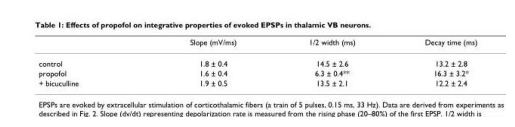

In [11]:
tdataset = TableDataset(data, img_size=None)
show_image(tdataset[0]['image'])

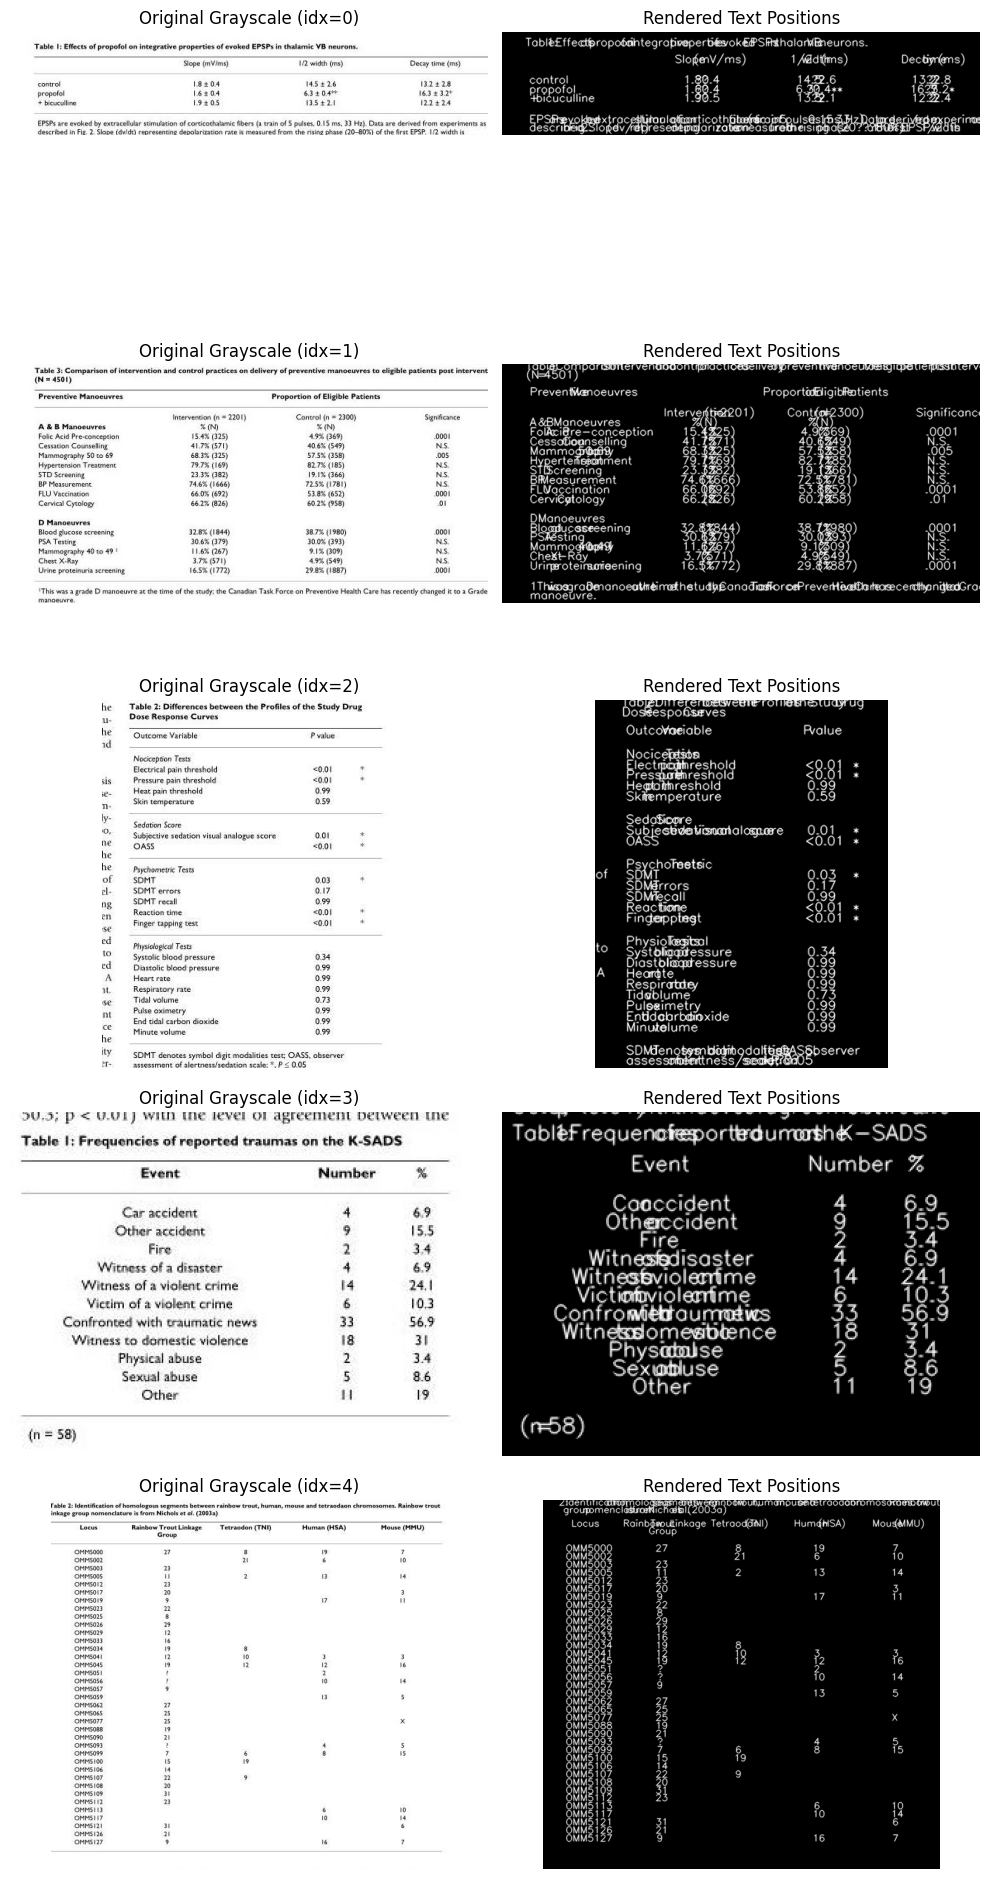

In [12]:
plot_image_vs_render([0,1,2,3,4], tdataset)

In [13]:
tdataset[4]['words'][0]

{'bbox': [-3.6414141414141454,
  2.230568181818171,
  23.131893939393933,
  13.90837121212121],
 'text': 'Table',
 'flags': 0,
 'span_num': 246,
 'line_num': 0,
 'block_num': 0}

In [14]:
np.unique(get_val_from_json(tdataset[4]['words'], val_name='flags'))

array([0])

C:\Users\jaabi\AppData\Local\Temp\ipykernel_6316\1502309802.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)
C:\Users\jaabi\AppData\Local\Temp\ipykernel_6316\1502309802.py:157: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


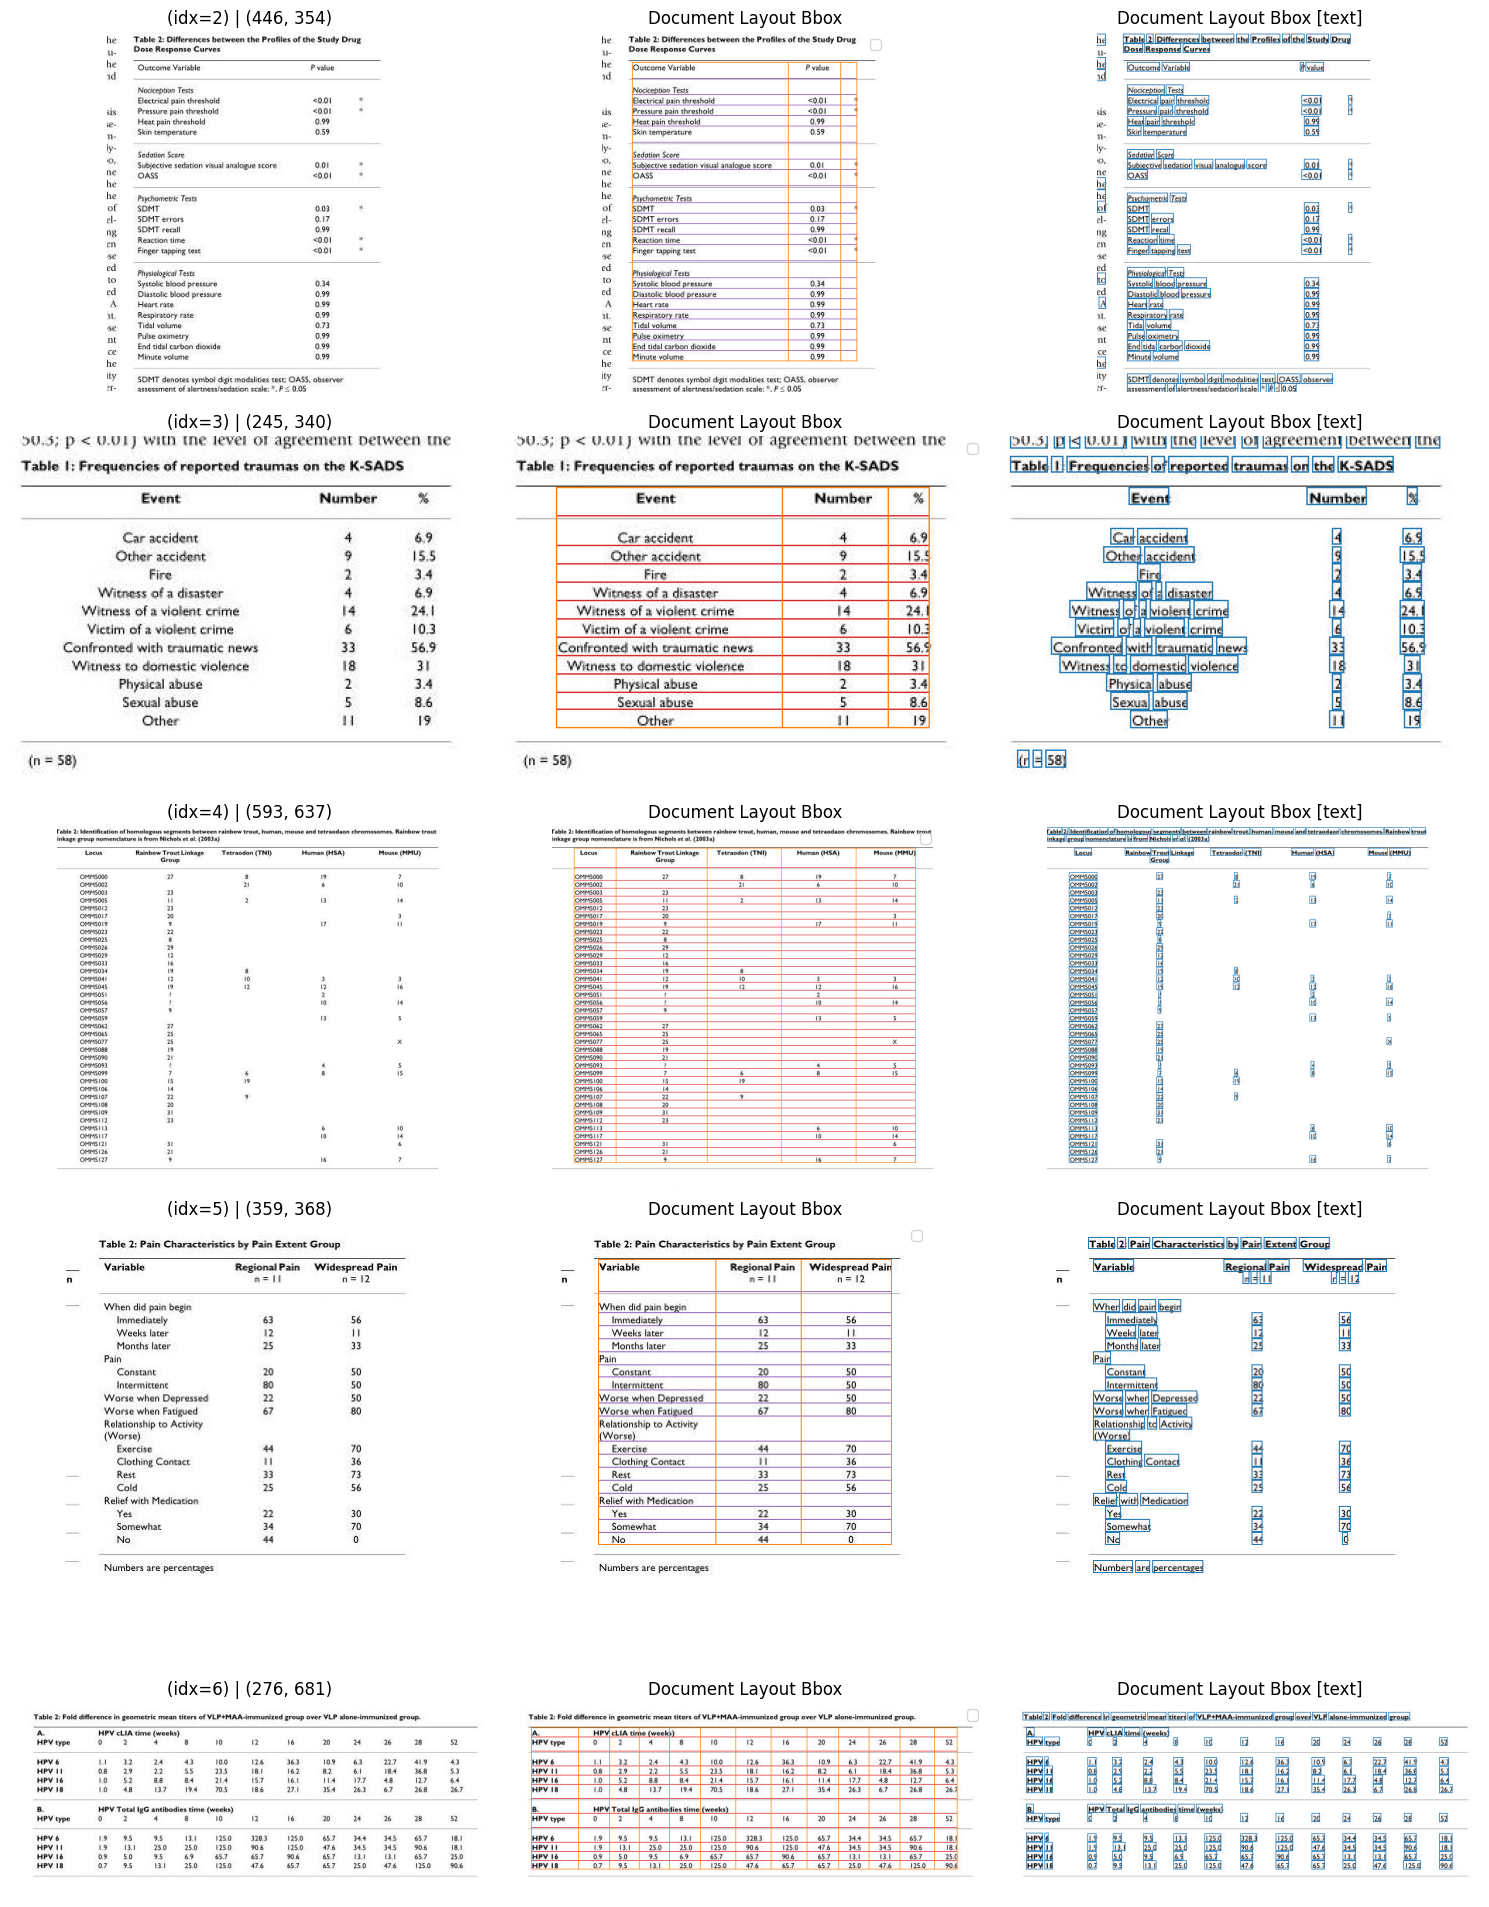

In [15]:
plot_image_and_bbox([2,3,4,5,6], tdataset);

In [16]:
for i in range(9):
    print(np.unique(get_val_from_json(tdataset[i]['words'], 'span_num')))

[626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643
 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661
 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679
 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697
 698 699 700 701 702 703 704 705 706 707 708 709 710 711 712 713 714 715
 716 717 718 719 720 721 722 723 724 725 726]
[317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334
 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352
 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370
 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388
 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406
 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424
 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442
 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460
 461 

Are these span nums random or fixed ID? 

A lot of these sample's span number seems to have the number ranged between 600-700

In [21]:
span_nums, texts = [], []

for i in range(5):
    snum = get_val_from_json(tdataset[i]['words'], 'span_num')
    text = get_val_from_json(tdataset[i]['words'], 'text')
    span_nums += snum
    texts += text

df = pd.DataFrame({
    'span_num': span_nums,
    'text' : texts
})


df.head()

,span_num,text
0,626,Table
1,627,1:
2,628,Effects
3,629,of
4,630,propofol


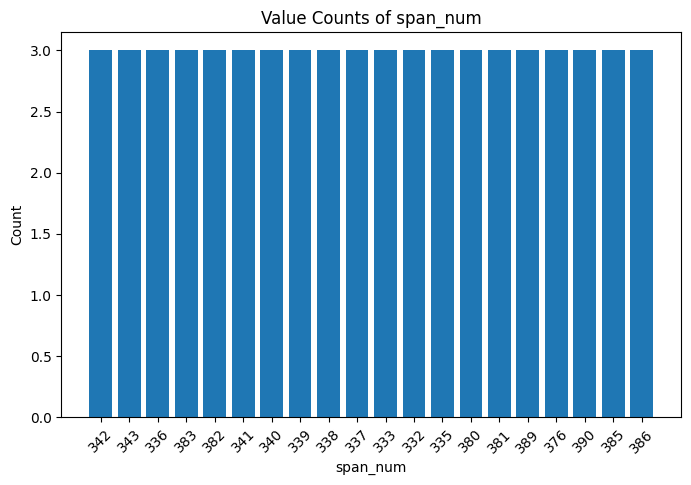

In [34]:
vc = df['span_num'].value_counts().sort_values(ascending=False).head(20)

# Extract index and values for plotting
x = vc.index.astype(str)   # make sure labels are strings
y = vc.values

plt.figure(figsize=(8,5))
plt.bar(x, y)
plt.xlabel("span_num")
plt.ylabel("Count")
plt.title("Value Counts of span_num")
plt.xticks(rotation=45)  # rotate labels if too crowded
plt.show()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622 entries, 0 to 621
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   span_num  622 non-null    int64 
 1   text      622 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.8+ KB


In [42]:
df[df.span_num == 626]

,span_num,text
0,626,Table
306,626,*


In [47]:
for sn in x:
    print(f'{sn} - {df[df.span_num == int(sn)].text.values}')

342 - ['Eligible' 'the' 'OMM5062']
343 - ['Patients' 'Table' '27']
336 - ['=' 'with' '14']
383 - ['(358)' 'crime' '31']
382 - ['57.5%' 'violent' 'OMM5121']
341 - ['of' 'between' '5']
340 - ['Proportion' 'agreement' '13']
339 - ['Manoeuvres' 'of' 'OMM5059']
338 - ['Preventive' 'level' '9']
337 - ['4501)' 'the' 'OMM5057']
333 - ['post' 'p' 'OMM5056']
332 - ['patients' '50.3;' '2']
335 - ['(N' '0.01)' '10']
380 - ['68.3%' 'of' '10']
381 - ['(325)' 'a' '14']
389 - ['82.7%' 'news' '16']
376 - ['Mammography' 'crime' 'OMM5113']
390 - ['(185)' '33' '7']
385 - ['Hypertension' '10.3' 'OMM5126']
386 - ['Treatment' 'Confronted' '21']


So from this we now know that span num is useless. They arent mapped to their respective value so its random mostly

In [48]:
df.span_num.describe()

count    622.000000
mean     466.319936
std      157.389745
min       23.000000
25%      347.000000
50%      402.500000
75%      643.750000
max      726.000000
Name: span_num, dtype: float64

In [51]:
tdataset[1]['words']

[{'bbox': [32.358585858585855,
   1.851717171717155,
   59.17622474747475,
   13.52950757575752],
  'text': 'Table',
  'flags': 0,
  'span_num': 317,
  'line_num': 0,
  'block_num': 0},
 {'bbox': [61.9178409090909,
   1.851717171717155,
   70.22429292929291,
   13.52950757575752],
  'text': '3:',
  'flags': 0,
  'span_num': 318,
  'line_num': 0,
  'block_num': 0},
 {'bbox': [72.96589646464646,
   1.851717171717155,
   131.1292297979798,
   13.52950757575752],
  'text': 'Comparison',
  'flags': 0,
  'span_num': 319,
  'line_num': 0,
  'block_num': 0},
 {'bbox': [133.87083333333334,
   1.851717171717155,
   142.91282828282826,
   13.52950757575752],
  'text': 'of',
  'flags': 0,
  'span_num': 320,
  'line_num': 0,
  'block_num': 0},
 {'bbox': [145.65444444444444,
   1.851717171717155,
   203.83895202020202,
   13.52950757575752],
  'text': 'intervention',
  'flags': 0,
  'span_num': 321,
  'line_num': 0,
  'block_num': 0},
 {'bbox': [206.58056818181817,
   1.851717171717155,
   223.70734

In [54]:
for i in range(9):
    print(np.unique(get_val_from_json(tdataset[-i]['words'], 'line_num')))

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


In [55]:
for i in range(9):
    print(np.unique(get_val_from_json(tdataset[i]['words'], 'block_num')))

[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]
[0]


Need to find all the possible features that might be good for the model to understand the document's layout. 

So far we have:

* text positions
* text indexes 
* line positions (can use but can be redundant since we already use block positions and text positions)
* line indexes
* block positions
* block indexes

After multiple checks I found out that the line indexes are not accurate, need to clean them. 

Also need to find a way for image size, each image arent equal in size. 

In [203]:

def padder(image, img_size=(842,595)):
    """
    Pads the input image to the target size by centering it
    on a black background.
    
    Args:
        img (np.ndarray): Input image (H, W, C).
        img_size (tuple): Target size (H, W). Size of an A4 page in pixels 
    
    Returns:
        np.ndarray: Padded image of shape img_size.
    """
    img = image.copy() * 255
    h, w = img.shape[:2]
    H, W = img_size
    print(f'original image shape: {h,w}')
    gray_img = len(img.shape) == 2
    # return img
    # Make sure input image fits
    if h > H or w > W:
        # Find scale factor (keep aspect ratio)
        scale = min(H / h, W / w)
        new_w, new_h = int(w * scale), int(h * scale)
        print(f'After resize image shape: {new_h,new_w}')
        img = cv2.resize(img, (new_w, new_h),  interpolation=cv2.INTER_AREA)
        h, w = img.shape[:2]
        
    # Create a black canvas
    padded = np.zeros((H, W) if gray_img else (H, W, 3), dtype=np.uint8) 
    # Compute top-left corner for centering
    y_offset = (H - h) // 2
    x_offset = (W - w) // 2

    # Place the image
    padded[y_offset:y_offset+h, x_offset:x_offset+w] = img 
    print(f'padded image shape: {padded.shape}')

    return padded


import albumentations as A
from albumentations.core.transforms_interface import DualTransform


class PadToSize(DualTransform):
    def __init__(self, target_size=(842, 595), always_apply=False, p=1.0):
        super(PadToSize, self).__init__(always_apply, p)
        self.H, self.W = target_size

    def apply(self, image, **params):
        """Pad the image (no bbox handling here)"""
        img = image.copy()
        h, w = img.shape[:2]
        H, W = self.H, self.W
        
        # Store original dimensions for bbox transformation
        self._original_h, self._original_w = h, w
        gray_img = len(img.shape) == 2
        
        self.scale = 1.0
        self.new_w, self.new_h = int(w * self.scale), int(h * self.scale)
        # Resize if too big
        if h > H or w > W:
            self.scale = min(H / h, W / w)
            self.new_w, self.new_h = int(w * self.scale), int(h * self.scale)
            img = cv2.resize(img, (self.new_w, self.new_h), interpolation=cv2.INTER_AREA)
            h, w = img.shape[:2]

        padded = np.zeros((H, W) if gray_img else (H, W, 3), dtype=np.uint8)
        y_offset = (H - h) // 2
        x_offset = (W - w) // 2
        padded[y_offset:y_offset + h, x_offset:x_offset + w] = img
        return padded

    def apply_to_bboxes(self, bboxes, **params):
        """
        Apply transformation to bounding boxes.
        Format: pascal_voc => [x_min, y_min, x_max, y_max]
        
        Args:
            bboxes: numpy array of shape (N, 4+) where each row is [x_min, y_min, x_max, y_max, ...]
        """
        if len(bboxes) == 0:
            return bboxes
        H, W = self.H, self.W
        image_h, image_w = self._original_h, self._original_w

        # Compute offsets after potential resize
        y_offset = (H - self.new_h) // 2
        x_offset = (W - self.new_w) // 2

        transformed_bboxes = bboxes.copy()
        # Apply scale if image was resized
        if self.scale != 1:
            transformed_bboxes[:, [0, 2]] *= self.scale  # x_min, x_max
            transformed_bboxes[:, [1, 3]] *= self.scale  # y_min, y_max

        # Apply padding offset
        transformed_bboxes[:, [0, 2]] += x_offset  # x_min, x_max
        transformed_bboxes[:, [1, 3]] += y_offset  # y_min, y_max

        print(f"Transformed bboxes shape: {transformed_bboxes.shape}")
        print(f"Target size: {self.H}x{self.W}")
        print(f"Scale factor: {self.scale}")
        print(f"Offsets: x={x_offset}, y={y_offset}")
        
        # Check for invalid bboxes
        for i, bbox in enumerate(transformed_bboxes):
            x_min, y_min, x_max, y_max = bbox[:4]
            
            # Check bounds
            if x_min < 0 or y_min < 0 or x_max > self.W or y_max > self.H:
                print(f"Bbox {i} outside bounds: [{x_min:.1f}, {y_min:.1f}, {x_max:.1f}, {y_max:.1f}]")
            
            # Check validity
            if x_min >= x_max or y_min >= y_max:
                print(f"Bbox {i} invalid: [{x_min:.1f}, {y_min:.1f}, {x_max:.1f}, {y_max:.1f}]")
            
            # Check size
            w, h = x_max - x_min, y_max - y_min
        if w < 1 or h < 1:
            print(f"Bbox {i} too small: {w:.1f}x{h:.1f}")
        return transformed_bboxes

    def get_transform_init_args_names(self):
        return ("target_size",)
    

def transform_image(image, struct, words, H = 842, W = 595):
    # Define augmentations
    transform = A.Compose([
        A.HueSaturationValue(p=0.5),
        A.CLAHE(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Rotate(limit=1, border_mode=cv2.BORDER_WRAP, p=0.7), 
        A.LongestMaxSize(max_size=max(H, W)),  # ensures the longest side == target max
        A.PadIfNeeded(min_height=H, min_width=W,
                      border_mode=cv2.BORDER_CONSTANT,
                      value=0),
        # A.Resize(H, W)
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['category_ids'], clip=True))

    # Extract bboxes from metadata
    sbboxes = get_val_from_json(struct, "bbox", 'objects')
    wbboxes = get_val_from_json(words, "bbox")
    sbboxes_len = len(sbboxes)
    wbboxes_len = len(wbboxes)
    bboxes = sbboxes + wbboxes
    category_ids = list(range(sbboxes_len + wbboxes_len))  
    print(np.array(bboxes).shape)
    # Apply transform
    augmented = transform(image=image, bboxes=bboxes, category_ids=category_ids)

    # Update the positions back into chunks_dict
    new_bboxes = augmented["bboxes"]
    augmented_ids = augmented["category_ids"]
    # mapper = kv_mapper(category_ids, texts)
    # new_chunks = replicate_chunks(new_bboxes, mapper, augmented_ids)
    # chunks_dict = upate_val_in_json(chunks_dict, "chunks", "pos", new_bboxes)
    return augmented["image"], new_bboxes

def denormalize_bboxes(bboxes, img_w, img_h):
    """Convert normalized bboxes back to pixel coordinates."""
    denorm_bboxes = []
    for (x_min, y_min, x_max, y_max) in bboxes:
        print(x_min, y_min, x_max, y_max)
        denorm_bboxes.append([
            x_min * img_w,
            y_min * img_h,
            x_max * img_w,
            y_max * img_h
        ])
    return denorm_bboxes

In [204]:
# plt.figure(figsize = (10, 13))
# pimg = padder(tdataset[0]['image'].numpy())
# show_image(pimg)
# plt.title(f'{pimg.shape}')

In [205]:
## the above padded image's og img. 
img = buffer_to_np(sample['name'] + '.jpg')
aimg, abbox = transform_image(img, sample['struct'], sample['words'])

(111, 4)


C:\Users\jaabi\AppData\Local\Temp\ipykernel_6316\2826459289.py:137: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=H, min_width=W,


C:\Users\jaabi\AppData\Local\Temp\ipykernel_6316\1502309802.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap)


Text(0.5, 1.0, '(842, 842, 3)')

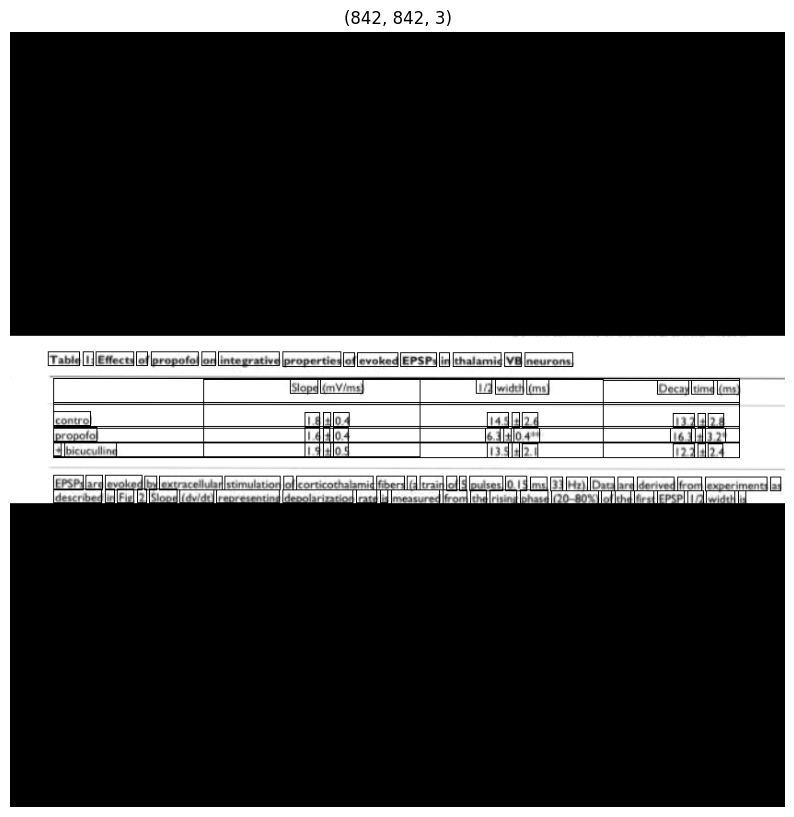

In [206]:
dabbox = [{'bbox': box, 'name': 'asdd'} for box in abbox]
plt.figure(figsize = (10, 13))
show_image(render_bbox(dabbox, aimg))
plt.title(f'{aimg.shape}')

Correcting the Line_nums and Block_nums 

In [58]:
sample['struct']

{'size': {'width': 657, 'height': 142},
 'objects': [{'name': 'table', 'bbox': [37.3586, 37.0904, 618.2697, 102.8725]},
  {'name': 'table column header',
   'bbox': [37.3586, 37.0904, 618.2697, 57.0645]},
  {'name': 'table row', 'bbox': [37.3586, 37.0904, 618.2697, 57.0645]},
  {'name': 'table row', 'bbox': [37.3586, 57.0645, 618.2697, 77.595]},
  {'name': 'table row', 'bbox': [37.3586, 77.595, 618.2697, 90.5119]},
  {'name': 'table row', 'bbox': [37.3586, 90.5119, 618.2697, 102.8725]},
  {'name': 'table column', 'bbox': [37.3586, 37.0904, 163.988, 102.8725]},
  {'name': 'table column', 'bbox': [163.988, 37.0904, 347.3245, 102.8725]},
  {'name': 'table column', 'bbox': [347.3245, 37.0904, 502.8367, 102.8725]},
  {'name': 'table column', 'bbox': [502.8367, 37.0904, 618.2697, 102.8725]}]}

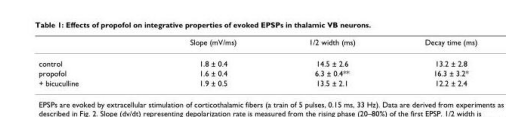

In [61]:
show_image(buffer_to_np(sample['name'] + '.jpg'))

Problem: These `struct` metadata contains the data only for the table not for the contents outside the table

Maybe construct a model with basic features 